In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import mne
import pathlib
import sklearn
import hdbscan
import seaborn as sns
import statistics
from meegkit import dss

from pycrostates.preprocessing import extract_gfp_peaks
from proof_of_consept import unit_normalize
from neurokit2.microstates.microstates_clean import microstates_clean
from mne_icalabel import label_components
from scipy.stats import kurtosis

In [2]:
def zapline_clean(raw, fline):
    data = raw.get_data().T # Convert mne data to numpy darray
    sfreq = raw.info['sfreq'] # Extract the sampling freq
   
    #Apply MEEGkit toolbox function
    out, _ = dss.dss_line(data, fline, sfreq, nkeep=1) # fline (Line noise freq) = 50 Hz for Europe
    print(out.shape)

    cleaned_raw = mne.io.RawArray(out.T, raw.info) # Convert output to mne RawArray again

    return cleaned_raw

In [3]:
data_folder = pathlib.Path(r"C:\Users\Gulbr\MasterOppgave\SRM_rs_EEG_OpenNeuro")
file = data_folder / "sub-002_ses-t1_task-resteyesc_eeg.edf"
#processed_folder = pathlib.Path(r"C:\Users\Gulbr\MasterOppgave\SRM_rs_EEG_OpenNeuro_cleaned")
#processed_file = processed_folder / "sub-001_ses-t1_task-resteyesc_desc-epochs_eeg.set"

raw = mne.io.read_raw_edf(file, preload=True, verbose=False)
mne.set_eeg_reference(raw, copy=False, verbose=False)
#Be carefull that artifact electrodes are not included in the average calc.
print(raw.info['ch_names'])
raw.set_montage('biosemi64')
#raw.drop_channels('O2')#raw.info["bads"].append("O2")
#mne.set_eeg_reference(raw, copy=False, verbose=False)
#raw.set_montage('biosemi64')

#bridged, dist = mne.preprocessing.compute_bridged_electrodes(raw)


raw_highpass = raw.copy().filter(l_freq=8, h_freq=None, verbose=False)
raw_lowpass = raw_highpass.copy().filter(l_freq=None, h_freq=12, verbose=False)
line_noise = zapline_clean(raw_lowpass, 50)
raw_down_sampled = line_noise.copy().resample(sfreq=200, verbose=False)
#I should maybe downsample, and maybe do it first for computational efficiency. The only thing is that then almost all the data will be in simpochs, so maybe I need stricter limits for gfp peakes.
#Bad segments can maybe be identified with Christoffers algorithm, anything else? I want to do this at the end of the pipeline I think.

['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']
[PCA] Explained variance of selected components : 54.76%
Power of components removed by DSS: 0.19
(245760, 64)
Creating RawArray with float64 data, n_channels=64, n_times=245760
    Range : 0 ... 245759 =      0.000 ...   239.999 secs
Ready.


In [4]:
print(raw_down_sampled.get_data().shape)

(64, 48000)


In [5]:
def gfp_normed_diss_data(indices, data, gfp):
    all_inx = np.arange(data.shape[1])
    unorderd_adj_indices = np.array([indices, (indices-1)]).flatten()
    anti_adj_indices = np.delete(all_inx, unorderd_adj_indices)
    all_inx = np.arange(data.shape[1])
    adj_indices = np.delete(all_inx, anti_adj_indices)

    indexed_data = data[:, adj_indices]
    indexed_gfp = gfp[adj_indices]

    gfp_normed = indexed_data/indexed_gfp


    return gfp_normed

def gfp_normed_diss_data2(indices, data, gfp):
    indexed_data = data[:, indices]
    indexed_gfp = gfp[indices]

    gfp_normed = indexed_data/indexed_gfp


    return gfp_normed

In [6]:
def diss(data, gfp, indices):
    gfp_normed_data = gfp_normed_diss_data(indices, data, gfp)
    diss = np.ndarray(shape=(len(indices), data.shape[0]))
    for t in range(0, len(indices)*2, 2):
        diss[int(t/2), :] = np.square(gfp_normed_data[:, t] - gfp_normed_data[:, t+1])
    return diss

def diss2(data, gfp, indices):
    gfp_normed_data = gfp_normed_diss_data2(indices, data, gfp)
    diss = np.ndarray(shape=(len(indices)-1, data.shape[0]))
    for t in range(1, len(indices)):
        diss[t-1, :] = np.square(gfp_normed_data[:, t] - gfp_normed_data[:, t-1])
    return diss

In [7]:
def epoched_stability(epochs_object):
    epochs_array = epochs_object.get_data()
    stability = np.ndarray(shape=(epochs_array.shape[0]))
    for e in range(epochs_array.shape[0]):
        data, indices, gfp, info_mne  = microstates_clean(epochs_array[e, :, :], standardize_eeg=False, normalize=False, gfp_method='l2', sampling_rate=epochs_object.info['sfreq'])
        d = diss(data, gfp, indices)
        stability[e] = np.mean(np.sqrt(np.mean(d, 1)))
    return stability

def epoched_stability2(epochs_object):
    epochs_array = epochs_object.get_data()
    stability = np.ndarray(shape=(epochs_array.shape[0]))
    convex_stability = np.ndarray(shape=(epochs_array.shape[0]))
    switching_freq = np.ndarray(shape=(epochs_array.shape[0]))
    significant_switching_freq = np.ndarray(shape=(epochs_array.shape[0]))
    peaks = np.ndarray(shape=(epochs_array.shape[0]))
    for e in range(epochs_array.shape[0]):
        data, indices, gfp, info_mne  = microstates_clean(epochs_array[e, :, :], standardize_eeg=False, normalize=False, gfp_method='l2', sampling_rate=epochs_object.info['sfreq'])
        d = diss2(data, gfp, indices)
        individual_map_stability = np.sqrt(np.mean(d, 1)) - 1
        for_convex = np.sqrt(np.mean(d, 1))
        freq = 0
        sfreq = 0
        for s in individual_map_stability:
            if s > 0:
                freq += 1
            if s > 0.4:
                sfreq += 1
        switching_freq[e] = freq
        significant_switching_freq[e] = sfreq
        stability[e] = np.mean(np.abs(individual_map_stability))
        convex_stability[e] = np.mean(for_convex)
        peaks[e] = len(indices)
    return stability, switching_freq, convex_stability, significant_switching_freq, peaks

Bad epoch idenfication - based on topographic stability

In [8]:
ones_epochs = mne.make_fixed_length_epochs(raw_down_sampled, verbose=False, overlap=0.5)

In [9]:
print(ones_epochs.get_data().shape)

Using data from preloaded Raw for 479 events and 200 original time points ...
0 bad epochs dropped
(479, 64, 200)


In [10]:
epoched_stability, epoched_switching_freq, convex_stabilty, significant_switching_freq, peaks = epoched_stability2(ones_epochs)

Using data from preloaded Raw for 479 events and 200 original time points ...


Plots to investigate exclusion of epocs not following our assumptions.

Epoch averaged DISS

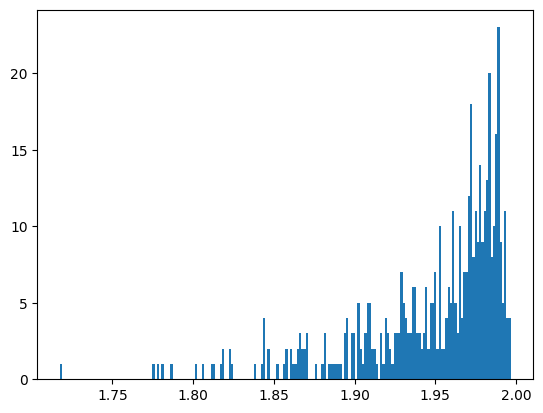

In [11]:
plt.hist(convex_stabilty, bins=200)
plt.show()

This is kind of a nonesesical plot as both 2 and 0 represents maximal stability. Stability values are therefor corrupted by averaging. Hovewer, the two timepoints idicating high stability by ways of low values (below 0.25) are clearly sepreated from the rest. These are epochs of high amplitude, low frequency noise. These are not corrupted by averageing as there is no polarity inversion happening, making them very distinct in the distribution. Question is are they seprable enough? What about very noisy EEG? Boxplot is not a good solution.

In [12]:
timepoints = np.where(convex_stabilty<0.6)[0]
print((timepoints)/2)

[]


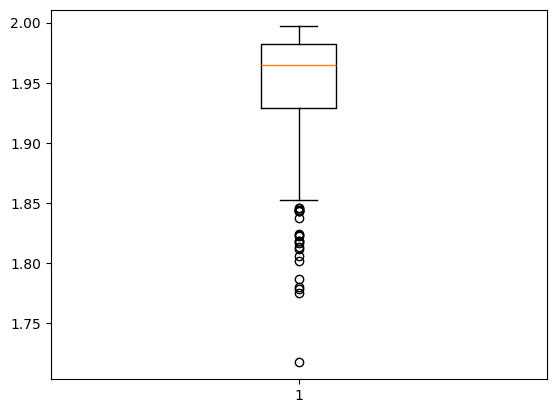

In [13]:
plt.boxplot(convex_stabilty)
plt.show()

Stability transformed: absoluteDISS = |DISS-1| ... and averaged for each epoch. Now only high values indicate stability.

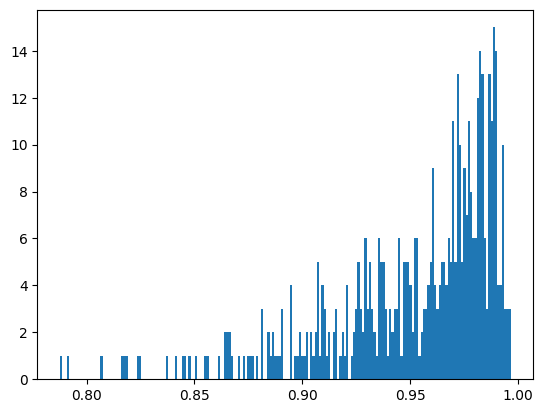

In [14]:
plt.hist(epoched_stability, bins=200)
plt.show()

Not a lot of good stability values, prob. because we have a lot of bad electrodes.

In [15]:
timepoints = np.where(epoched_stability<0.25)[0]
print((timepoints)/2)

[]


Average epoch polarity inversion going from gfp peak to gfp peak, meaning DISS < 1.

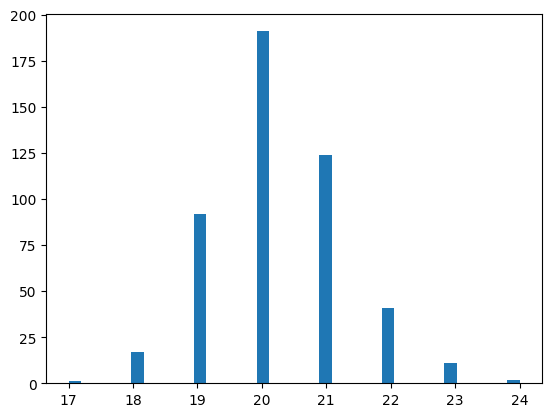

In [16]:
plt.hist(epoched_switching_freq, bins=36)
plt.show()

In [17]:
timepoints = np.where(epoched_switching_freq>30)[0]
print((timepoints)/2)

[]


In [18]:
timepoints = np.where(epoched_switching_freq>26)[0]
print((timepoints)/2)

[]


In [19]:
timepoints = np.where(epoched_switching_freq<3)[0]
print((timepoints)/2)

[]


The same again, but only for shifts in polarity where higher stability is indicated (DISS > 1.4)

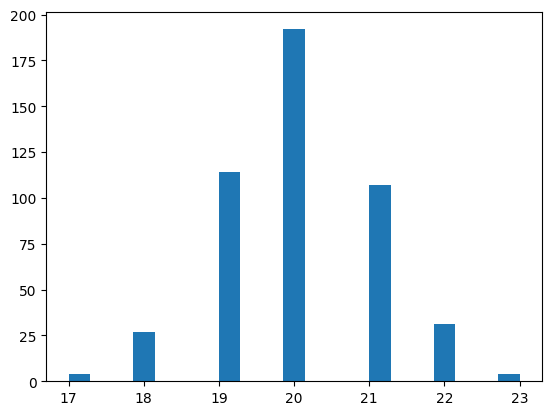

In [20]:
plt.hist(significant_switching_freq, bins=21)
plt.show()

Here there are no epochs with zero switching, in the other very clean EEG that was the case.

Number of GFP peaks for each epoch

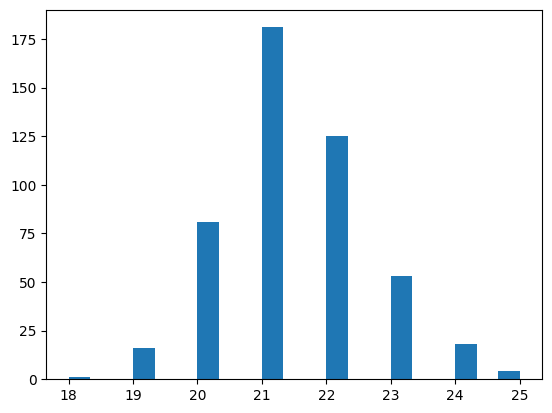

In [21]:
plt.hist(peaks, bins=21)
plt.show()

In [22]:
timepoints = np.where(peaks>50)[0]
print((timepoints)/2)

[]


Looking at scatter plot between swithcing frequencies and number of GFP peaks

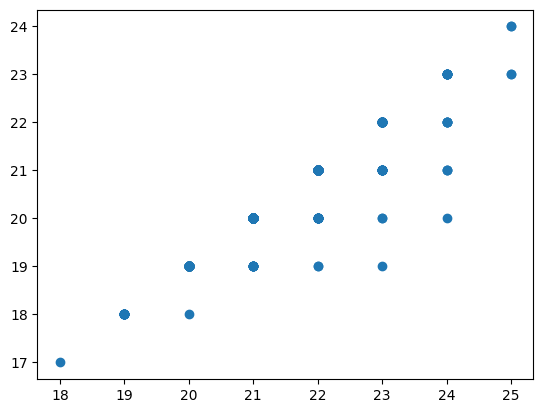

In [23]:
plt.scatter(peaks, epoched_switching_freq)
plt.show()

In [24]:
idx = np.where((epoched_switching_freq < 2))[0]
print((idx-1)/2)

[]


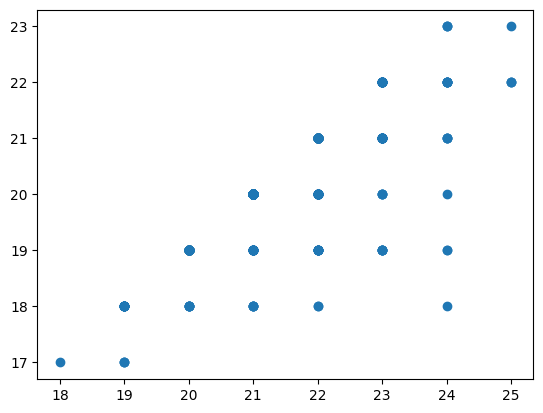

In [25]:
plt.scatter(peaks, significant_switching_freq)
plt.show()

THE IMPORTANT ONE? Looking here we dont see the convex thing AND we see the other side of the maybe convex thing. So either all epochs are bad, or there is a lot of high frequency channel noise. I know the latter to be true. Maybe adjust sign switch?

In [26]:
idx = np.where((peaks > 50))[0]
print((idx-1)/2)

idx = np.where((peaks < 28) & (significant_switching_freq < 9))[0]
print((idx-1)/2)

idx = np.where((significant_switching_freq == 0))[0]
print((idx-1)/2)

[]
[]
[]


Looking at average absoluteDISS in relation to switching frequencies.

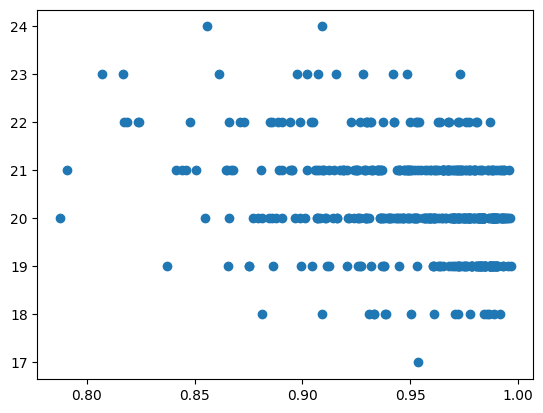

In [27]:
plt.scatter(epoched_stability, epoched_switching_freq)
plt.show()

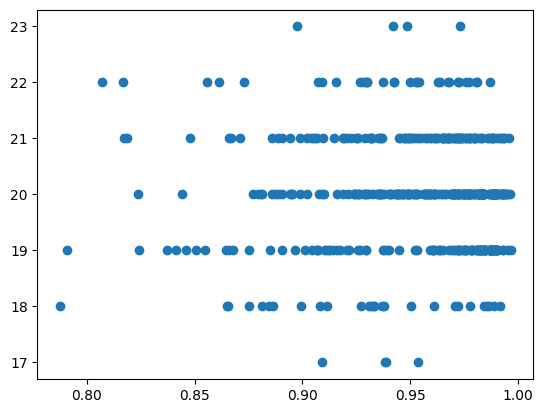

In [28]:
plt.scatter(epoched_stability, significant_switching_freq)
plt.show()

No clear relationship here, just big blobs.... Overall very wierd datarepresenations here, maybe tune significant swithing level? Or maybe the bad elctrodes disrupts to much? or maybe the relationships in the last eeg is not generalizale.

In [29]:
idx = np.where((epoched_stability > 0.5) & (significant_switching_freq < 5))[0]
print((idx-1)/2)

[]


Same but with average DISS

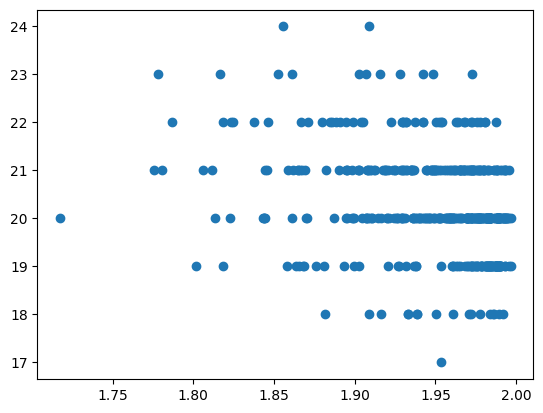

In [30]:
plt.scatter(convex_stabilty, epoched_switching_freq)
plt.show()

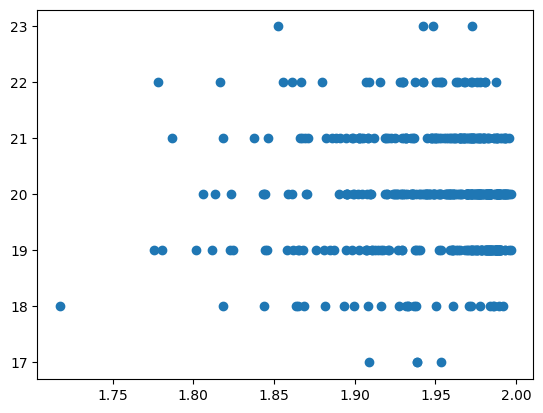

In [31]:
plt.scatter(convex_stabilty, significant_switching_freq)
plt.show()

A bit more clear relationship here.

In [32]:
print(epoched_stability[110*2+1], convex_stabilty[110*2+1], epoched_switching_freq[110*2+1], significant_switching_freq[110*2+1])

0.965487964493882 1.9654879644938823 21.0 21.0


In [33]:
print(epoched_stability[int(109.5*2)+1], convex_stabilty[int(109.5*2)+1], epoched_switching_freq[int(109.5*2)+1], significant_switching_freq[int(109.5*2)+1])

0.9811888915547546 1.9811888915547544 20.0 20.0


Scatter of the two stability types

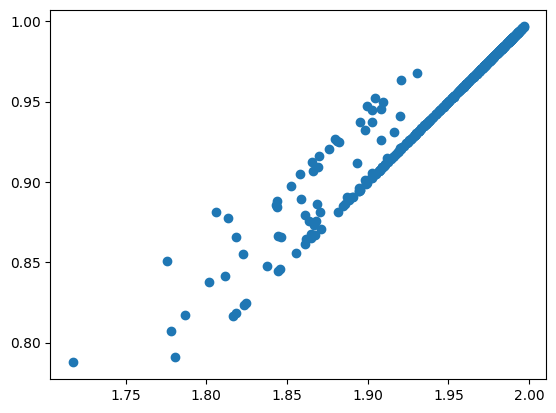

In [34]:
plt.scatter(convex_stabilty, epoched_stability)
plt.show()

In [35]:
idx = np.where((epoched_stability>0.4) & (convex_stabilty<0.75))[0]
print((idx)/2)

[]


THE IMPORTANT ONE? So if I were to generalize my thoughts from the first eeg, I would say here there is no trend of a convex function, meaning we dont have a lot of high amplitude low frequency noise and not much eye activity.

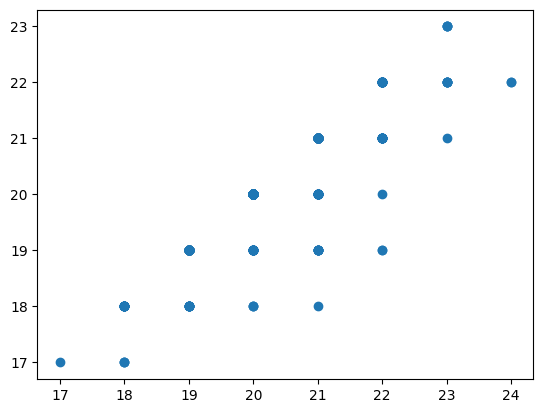

In [36]:
plt.scatter(epoched_switching_freq, significant_switching_freq)
plt.show()

In [37]:
idx = np.where((epoched_switching_freq > 25) & (significant_switching_freq < 15))[0]
print((idx-1)/2)

[]


This was very different, but i think maybe it makes sense. Looking at the EEG it does not look like we have any bad epochs really. BUT there a lot of bad channels!

In [38]:
channel_names = np.array(raw_down_sampled.info['ch_names'])

In [39]:
data, indices, gfp, info_mne  = microstates_clean(raw_down_sampled, standardize_eeg=False, normalize=False, gfp_method='l2')
print(indices.shape, gfp.shape, data.shape)
gfp_peakes = gfp[indices]
print(gfp_peakes.shape)
#new_indices = np.argpartition(gfp_peakes, -1000)[-1000:]
#new_indices = np.sort(new_indices)
#print(new_indices)
#print(new_indices.shape)
gfp_data = data[:, indices]#[:, new_indices]
#print(neuro_gfp_data.shape)

(5188,) (48000,) (64, 48000)
(5188,)


2.8492090638463525e-06


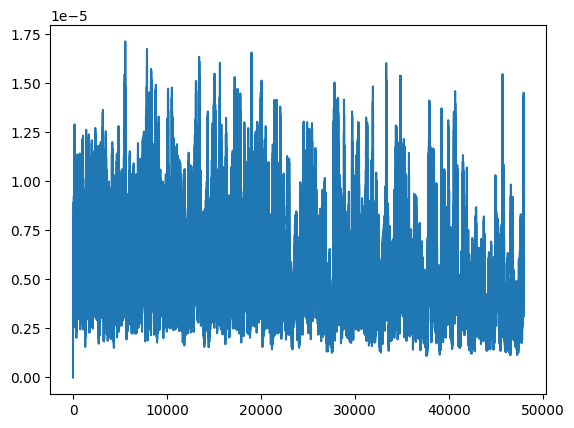

In [40]:
print(np.std(gfp_peakes))
plt.plot(gfp)
plt.show()

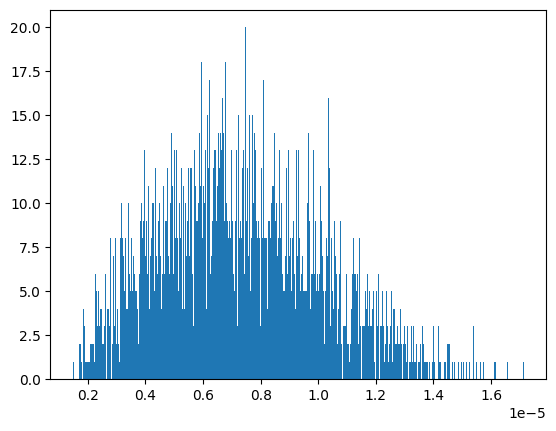

In [41]:
plt.hist(gfp_peakes, bins=1000)
plt.show()

In [42]:
print(kurtosis(gfp_peakes))

-0.3060929796825649


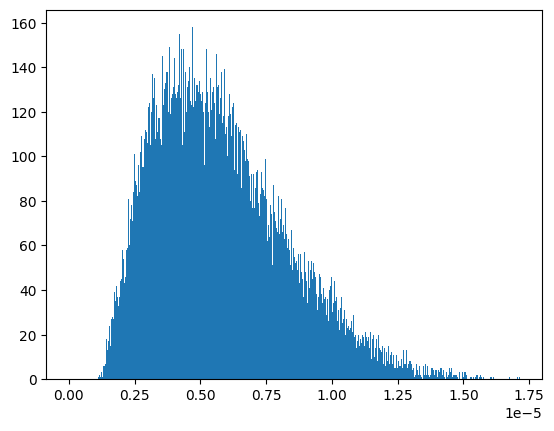

In [43]:
plt.hist(gfp, bins=1000)
plt.show()

In [44]:
print(kurtosis(gfp))
print(np.std(gfp))
print(np.mean(gfp))
print(np.mean(gfp) + np.std(gfp)*5)

0.30191070525630925
2.543690595772777e-06
5.8192612896006726e-06
1.8537714268464557e-05


In [45]:
#print(np.where(gfp_peakes>0.4)[0])
#indices = np.delete(indices, np.arange(3183, 3258, 1))
#gfp_peakes = np.delete(gfp_peakes, np.arange(3183, 3258, 1))
#indices = np.delete(indices, np.where(gfp_peakes>0.4)[0])
#gfp_peakes = np.delete(gfp_peakes, np.where(gfp_peakes>0.4)[0])


2.8492090638463525e-06


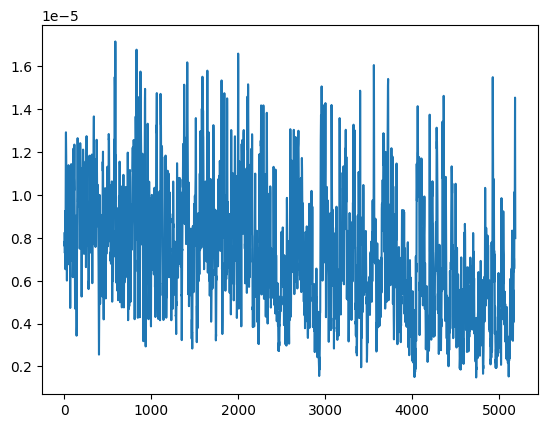

In [46]:
print(np.std(gfp_peakes))
plt.plot(gfp_peakes)
plt.show()

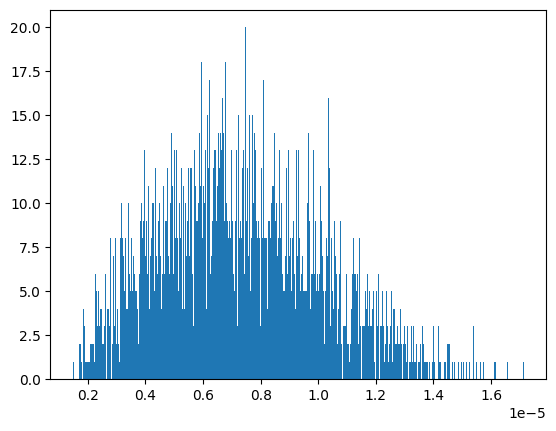

In [47]:
plt.hist(gfp_peakes, bins=1000)
plt.show()

In [48]:
print(kurtosis(gfp_peakes))

-0.3060929796825649


In [49]:
print(indices.shape)

(5188,)


In [50]:
print(np.average(gfp))
print(np.std(gfp))

5.8192612896006726e-06
2.543690595772777e-06


In [51]:
gfp_peakes = gfp[indices]
print(gfp_peakes.shape)
gfp_data = data[:, indices]
print(gfp_data.shape)

(5188,)
(64, 5188)


2.8492090638463525e-06


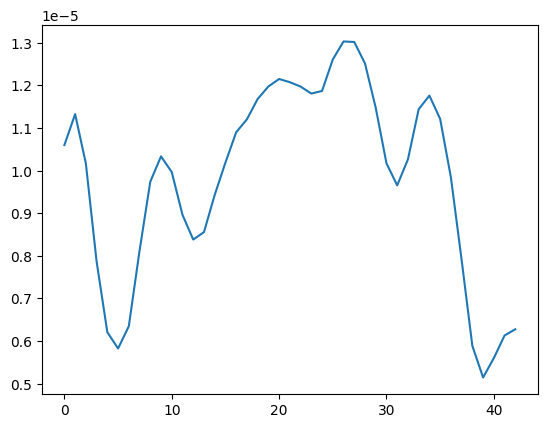

In [52]:
print(np.std(gfp_peakes))
plt.plot(gfp_peakes[3210:3253])
plt.show()
#Something wierd here for sure...

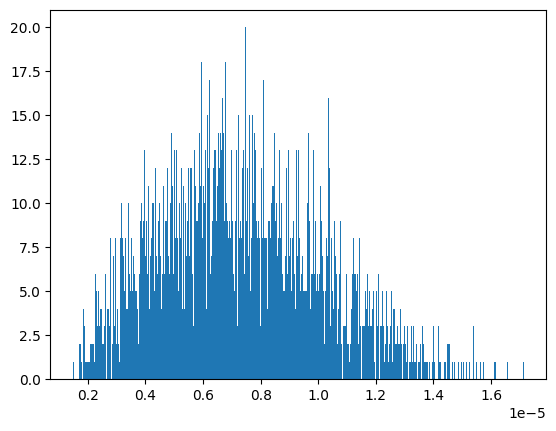

In [53]:
plt.hist(gfp_peakes, bins=1000)
plt.show()

In [54]:
print(kurtosis(gfp))

0.30191070525630925


2.8492090638463525e-06


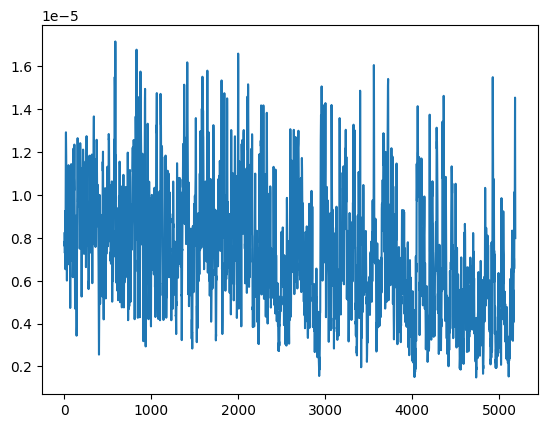

In [55]:
print(np.std(gfp_peakes))
plt.plot(gfp_peakes)
plt.show()
#Something wierd here for sure...

In [56]:
"""gfp_peakes = extract_gfp_peaks(raw_down_sampled, min_peak_distance=1)
print(gfp_peakes.get_data().shape)
top_indices = np.argpartition(np.std(gfp_peakes.get_data(), axis=0), -6003)[-6003:]
print(top_indices.shape)
gfp_data = gfp_peakes.get_data()[:, top_indices]
print(gfp_data.shape)"""

'gfp_peakes = extract_gfp_peaks(raw_down_sampled, min_peak_distance=1)\nprint(gfp_peakes.get_data().shape)\ntop_indices = np.argpartition(np.std(gfp_peakes.get_data(), axis=0), -6003)[-6003:]\nprint(top_indices.shape)\ngfp_data = gfp_peakes.get_data()[:, top_indices]\nprint(gfp_data.shape)'

In [57]:
all_inx = np.arange(raw_down_sampled.get_data().shape[1])
drop = np.delete(all_inx, indices)
sim_indices = np.array([indices, (indices-1)]).flatten()
all_inx = np.arange(raw_down_sampled.get_data().shape[1])
simpochs_indices = np.delete(all_inx, sim_indices)


In [58]:
print(len(all_inx))
print(indices.shape)
print(sim_indices.shape)

48000
(5188,)
(10376,)


In [59]:
print(drop.shape)
print(simpochs_indices.shape) #Something wierd here...

(42812,)
(37624,)


In [60]:
print(indices)
print(sim_indices)

[    5    17    27 ... 47980 47989 47997]
[    5    17    27 ... 47979 47988 47996]


In [61]:
epochs = mne.make_fixed_length_epochs(raw_down_sampled, duration = 1/raw_down_sampled.info['sfreq'], verbose=False, preload=True)

In [62]:
print(epochs.info)

<Info | 10 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG
 custom_ref_applied: True
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 8.0 Hz
 lowpass: 12.0 Hz
 meas_date: 2021-08-24 10:57:38 UTC
 nchan: 64
 projs: []
 sfreq: 200.0 Hz
 subject_info: 1 item (dict)
>


In [63]:
epochs.drop(drop)

Dropped 42812 epochs: 0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 106, 107, 108, 109, 110, 111, 113, 114, 115, 116, 117, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 130, 131, 132, 133, 134, 135, 136, 137, 139, 140, 141, 142, 143, 144, 145, 147, 148, 149, 150, 151, 152, 153, 154, 156, 157, 158, 159, 160, 161, 162, 163, 165, 166, 167, 168, 169, 170, 171, 172, 174, 175, 176, 177, 178, 179, 180, 182, 183, 184, 185, 186, 187, 188, 189, 191, 192, 193, 194, 195, 196, 197, 198, 199, 201, 202, 203, 204, 205, 206, 207, 208, 210, 211, 212, 213, 214, 215, 216, 217, 218, 220, 221, 222, 223, 224, 225, 226, 227, 228, 230, 231, 232, 233, 234, 235, 236, 237, 238, 240, 241, 2

<Epochs |  5188 events (all good), 0 – 0 s, baseline off, ~2.6 MB, data loaded,
 '1': 5188>

In [64]:
simpochs = mne.make_fixed_length_epochs(raw_down_sampled, duration = 1/raw_down_sampled.info['sfreq'], verbose=False, preload=True)

In [65]:
simpochs.drop(simpochs_indices)

Dropped 37624 epochs: 0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30, 31, 32, 33, 34, 37, 38, 39, 40, 41, 42, 43, 46, 47, 48, 49, 50, 51, 52, 55, 56, 57, 58, 59, 60, 63, 64, 65, 66, 67, 68, 69, 72, 73, 74, 75, 76, 77, 78, 81, 82, 83, 84, 85, 86, 87, 90, 91, 92, 93, 94, 95, 96, 99, 100, 101, 102, 103, 106, 107, 108, 109, 110, 113, 114, 115, 116, 117, 118, 119, 122, 123, 124, 125, 126, 127, 130, 131, 132, 133, 134, 135, 136, 139, 140, 141, 142, 143, 144, 147, 148, 149, 150, 151, 152, 153, 156, 157, 158, 159, 160, 161, 162, 165, 166, 167, 168, 169, 170, 171, 174, 175, 176, 177, 178, 179, 182, 183, 184, 185, 186, 187, 188, 191, 192, 193, 194, 195, 196, 197, 198, 201, 202, 203, 204, 205, 206, 207, 210, 211, 212, 213, 214, 215, 216, 217, 220, 221, 222, 223, 224, 225, 226, 227, 230, 231, 232, 233, 234, 235, 236, 237, 240, 241, 242, 243, 244, 245, 246, 247, 250, 251, 252, 253, 254, 255, 256, 259, 260, 261, 262, 263, 264, 265, 268, 269, 270, 271, 272,

<Epochs |  10376 events (all good), 0 – 0 s, baseline off, ~5.2 MB, data loaded,
 '1': 10376>

In [66]:
ica = mne.preprocessing.ICA(max_iter="auto",
    method="infomax",
    random_state=97,
    fit_params=dict(extended=True),
    )

In [67]:
ica.fit(epochs)
#Do I feed enough data to ICA?

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 63 components
Computing Extended Infomax ICA
Fitting ICA took 16.9s.


<ICA | epochs decomposition, method: infomax (fit in 500 iterations on 5188 samples), 63 ICA components (64 PCA components available), channel types: eeg, no sources marked for exclusion>

Creating RawArray with float64 data, n_channels=63, n_times=48000
    Range : 0 ... 47999 =      0.000 ...   239.995 secs
Ready.
Using matplotlib as 2D backend.


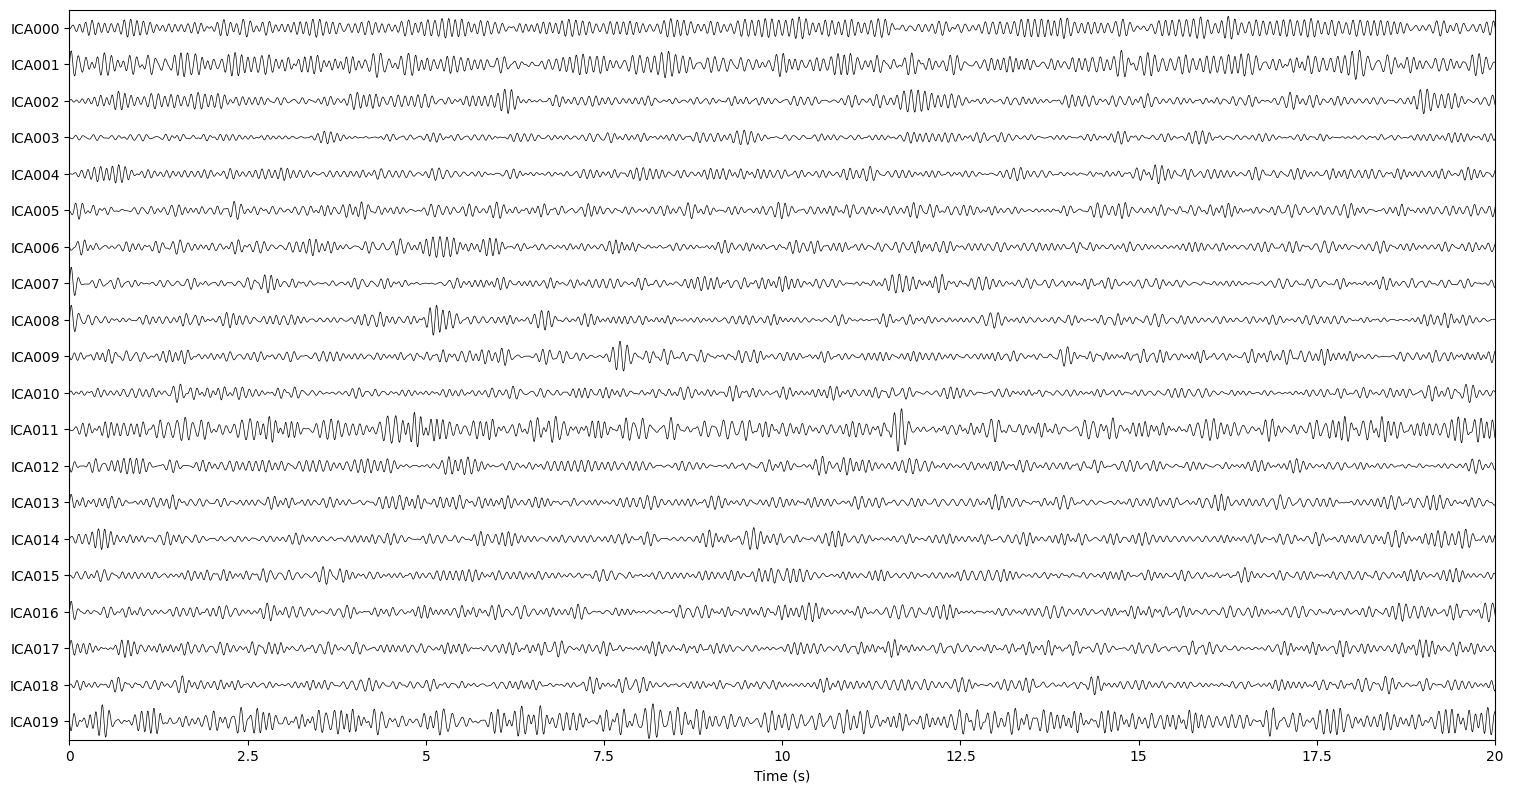

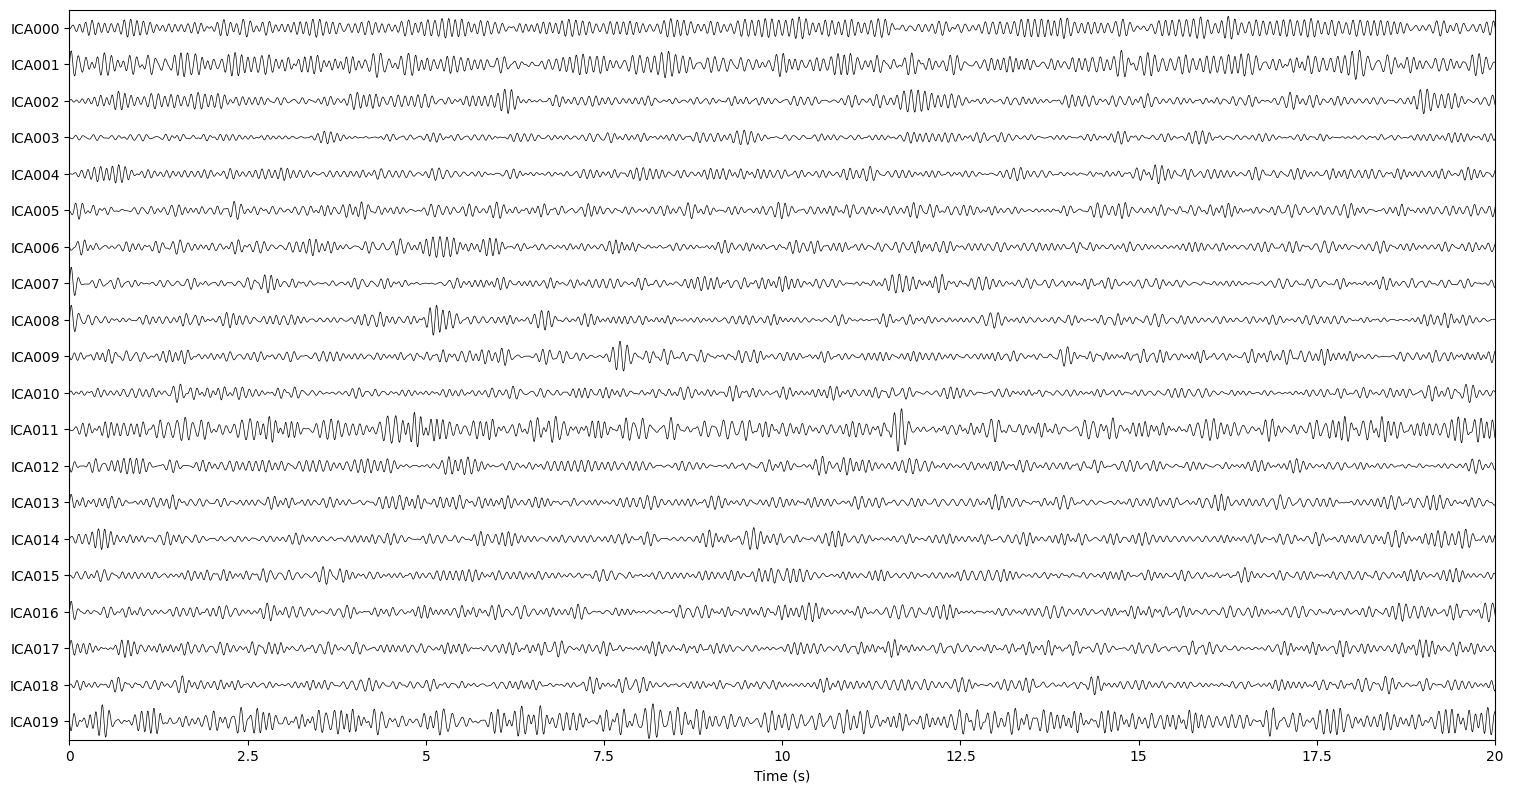

In [68]:
ica.plot_sources(raw_down_sampled, show_scrollbars=False, show=True)

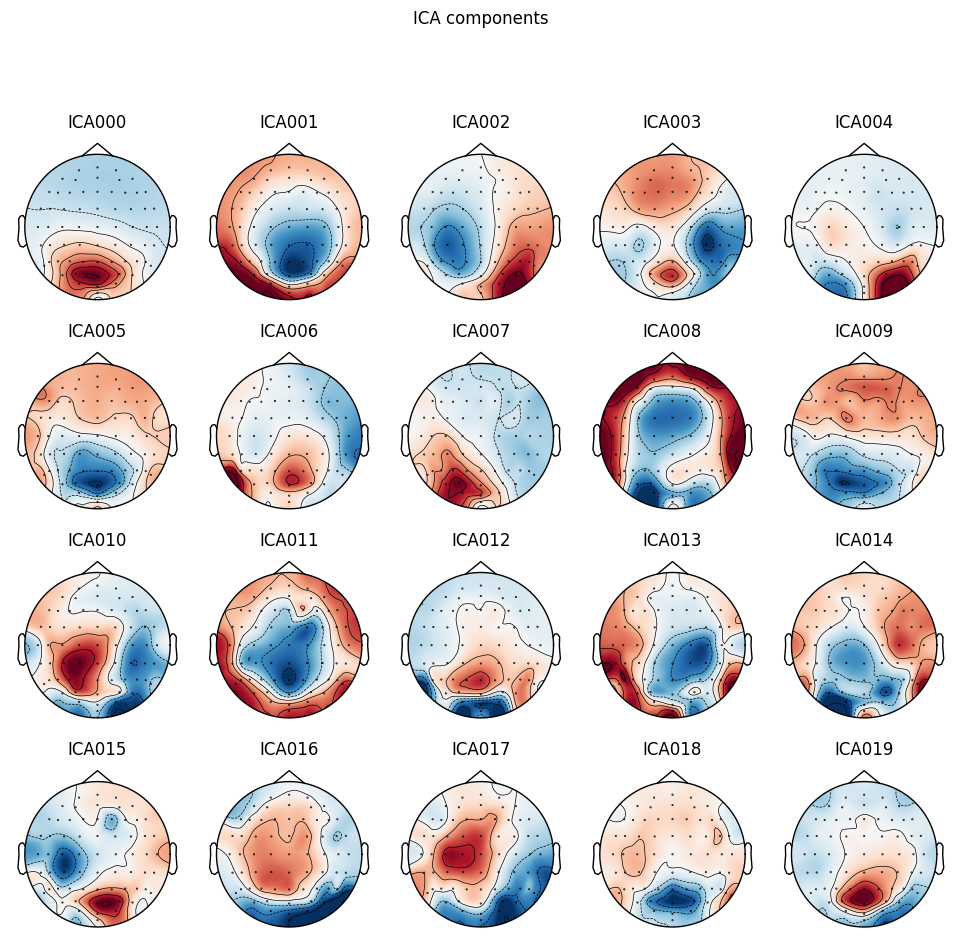

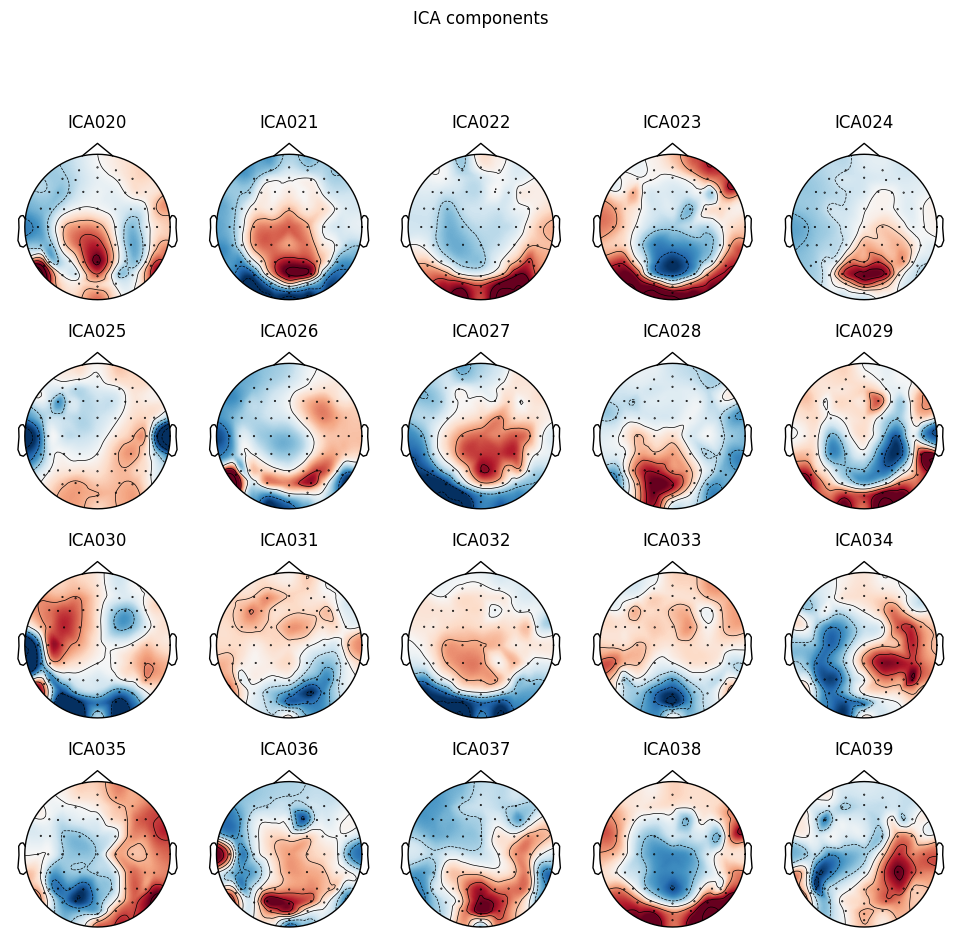

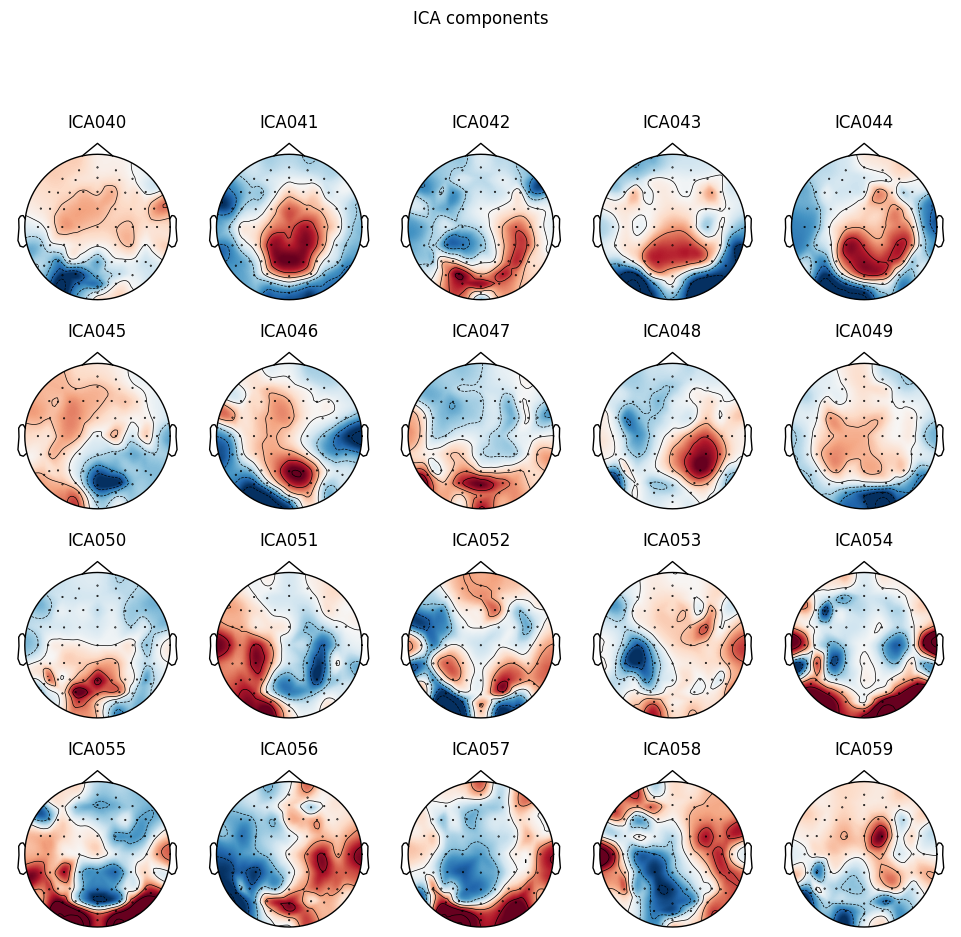

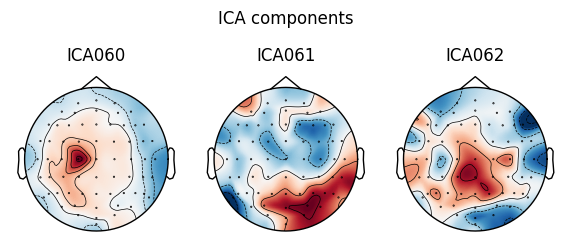

[<MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 585x260.5 with 3 Axes>]

In [69]:
ica.plot_components()
#Something wierd with component 1 here for sure, hence the wish for bad segment excluder. 

In [70]:
ic_labels = label_components(raw_down_sampled, ica, method='iclabel')

C:\Users\Gulbr\AppData\Local\Temp\ipykernel_24756\1066216419.py:1: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_down_sampled, ica, method='iclabel')


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [71]:
print(ic_labels)

{'y_pred_proba': array([0.99999475, 0.99918616, 0.99998474, 0.99962837, 0.9971641 ,
       0.9998834 , 0.9987404 , 0.974423  , 0.9536779 , 0.99827665,
       0.9879377 , 0.99547416, 0.94769514, 0.9649807 , 0.99671125,
       0.9971642 , 0.95659494, 0.9294403 , 0.98932076, 0.9986853 ,
       0.99778044, 0.9947837 , 0.96354216, 0.8399841 , 0.9993309 ,
       0.98232806, 0.99657905, 0.96459013, 0.99711055, 0.9879104 ,
       0.9757038 , 0.9985094 , 0.94609636, 0.9686843 , 0.9950372 ,
       0.98238134, 0.9846518 , 0.9777505 , 0.8553187 , 0.99021876,
       0.87106144, 0.949265  , 0.993523  , 0.99270433, 0.98672193,
       0.992391  , 0.68929666, 0.97653   , 0.9959643 , 0.98194504,
       0.8723682 , 0.9856621 , 0.8310526 , 0.98882425, 0.92474055,
       0.56661344, 0.9895042 , 0.7205196 , 0.92007923, 0.9875452 ,
       0.9782542 , 0.8781538 , 0.8188982 ], dtype=float32), 'labels': ['brain', 'brain', 'brain', 'brain', 'brain', 'brain', 'brain', 'brain', 'brain', 'brain', 'brain', 'brain', 

In [72]:
s = ica.get_sources(epochs)

In [73]:
s.get_data().shape

(5188, 63, 1)

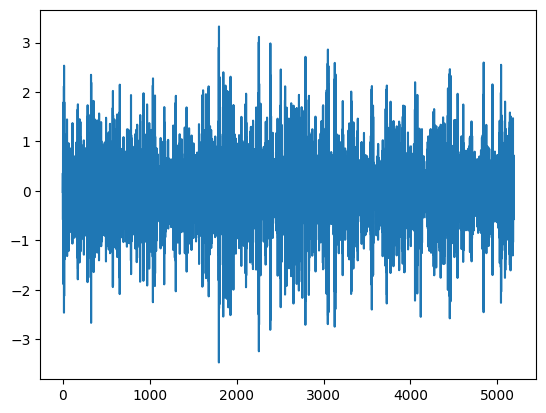

In [74]:
plt.plot(s.get_data()[:, 4, 0])
plt.show()

In [75]:
print(s.get_data()[1, 0, 0], s.get_data()[1, 1, 0], s.get_data()[1, 2, 0], s.get_data()[1, 3, 0], s.get_data()[1, 4, 0], s.get_data()[1, 5, 0], s.get_data()[1, 6, 0])

-0.6597616558967505 -2.1471997504327844 0.10928674489863864 0.5741869206923098 0.3585642937668519 1.9999262660237314 0.1435983081194997


In [76]:
print(simpochs.get_data().shape)

(10376, 64, 1)


ICA charachteristics

In [77]:
from scipy.stats import median_abs_deviation

In [78]:
comps = ica.get_components()
comp_gfp_mad = median_abs_deviation(comps, 0)
comp_gfp_std = np.std(comps, 0)

In [79]:

print(comp_gfp_mad.shape)

(63,)


In [80]:
print(comp_gfp_mad)

[0.28034379 0.12575275 0.26272503 0.15300979 0.06500078 0.09530575
 0.06907048 0.0620524  0.09155806 0.08857809 0.06260435 0.04297368
 0.0507088  0.06145576 0.06423777 0.04160873 0.06297502 0.05788312
 0.02863595 0.02127271 0.05610154 0.02597726 0.03969469 0.0606441
 0.0457297  0.05929387 0.06097461 0.04930543 0.0325102  0.03656327
 0.05485248 0.02096666 0.03151812 0.03204419 0.05573883 0.03123621
 0.04343946 0.04770007 0.02556048 0.03771813 0.01713753 0.03882514
 0.039661   0.02549472 0.04152807 0.03026921 0.03435694 0.0232723
 0.0178839  0.02988111 0.02869722 0.03277787 0.03501858 0.01201981
 0.0196449  0.03658413 0.03922043 0.01604569 0.03157415 0.02230612
 0.02329173 0.02492221 0.02394377]


In [81]:
print(comp_gfp_std)

[0.51575858 0.22006272 0.3961436  0.19936961 0.16421993 0.14958317
 0.12120315 0.12179296 0.11718574 0.10682136 0.1055528  0.05748103
 0.10442671 0.10256645 0.09885675 0.09704569 0.09378845 0.09059019
 0.08722803 0.04740052 0.08634412 0.04708253 0.0860914  0.08571184
 0.08486254 0.08229119 0.08070329 0.07815709 0.07644201 0.07508196
 0.07467085 0.04008746 0.0735854  0.07336637 0.07106686 0.03708362
 0.06808878 0.06711772 0.03624481 0.06575221 0.03522748 0.06462889
 0.0640972  0.06381531 0.06079239 0.06096211 0.05987062 0.03243485
 0.03098438 0.05679477 0.05475598 0.05349818 0.04980571 0.02653428
 0.04819077 0.04714437 0.04651887 0.02512687 0.04384145 0.04340306
 0.04062842 0.04044403 0.03744289]


the square root of the mean of squared differences between GFP normalized electrodes.

In [82]:
print(data.shape)

(64, 48000)


In [83]:
d = diss2(data, gfp, indices)
print(d.shape)

(5187, 64)


In [84]:
stability = np.sqrt(np.mean(d, axis=0))
print(stability.shape)

(64,)


In [85]:
print(stability)

[1.50530001 1.51292339 1.46705522 1.43388607 1.3913046  1.44004662
 1.43553596 1.36921648 1.24042789 1.29650444 1.35239782 1.43363166
 1.55478119 1.16107165 1.48843464 1.44473076 1.43314253 2.05963883
 2.01358453 2.93490857 2.39629565 1.92350516 1.68450269 2.03318538
 2.62433796 3.81323474 3.552071   1.912326   3.13248937 4.31140659
 3.20470033 1.81228636 1.50970769 1.5159709  1.48735961 1.4450651
 1.47594741 1.44743183 1.59649331 1.44343095 1.48888884 1.44819895
 1.45783956 1.42084413 1.4500177  1.44954544 1.35013109 1.31758692
 1.3321763  1.78728481 1.42379011 1.6993553  1.55627051 1.48372522
 1.93200036 1.71112269 2.49749239 1.98442105 1.77652731 1.72376796
 1.78832478 2.29694726 3.03490509 2.83427299]


In [86]:
order = np.argsort(stability)
print(channel_names[order])

['C5' 'FC5' 'FC3' 'Cz' 'C2' 'FCz' 'FC1' 'FT7' 'F3' 'FC6' 'C6' 'CP5' 'C1'
 'F1' 'F7' 'F5' 'F4' 'TP7' 'AF4' 'Fz' 'F8' 'FC2' 'FC4' 'FT8' 'AF3' 'AFz'
 'CP6' 'AF8' 'T7' 'F6' 'Fp1' 'Fpz' 'AF7' 'Fp2' 'C3' 'TP8' 'F2' 'P7' 'T8'
 'CP2' 'P8' 'P6' 'C4' 'P10' 'CPz' 'Iz' 'P5' 'CP4' 'P4' 'CP1' 'P9' 'CP3'
 'PO8' 'P3' 'P2' 'PO7' 'O2' 'P1' 'PO4' 'Oz' 'Pz' 'O1' 'PO3' 'POz']


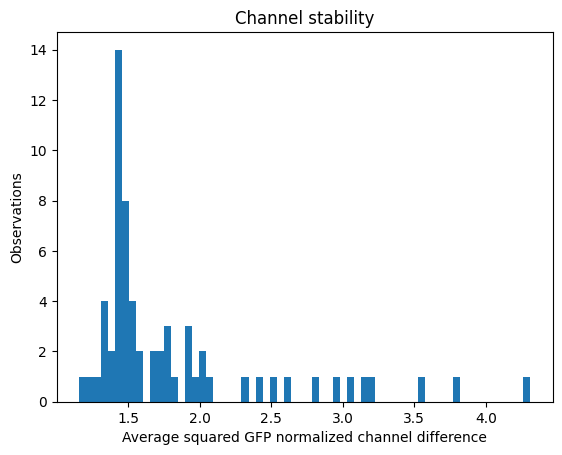

In [87]:
plt.hist(stability, bins=64)
plt.xlabel('Average squared GFP normalized channel difference')
plt.ylabel('Observations')
plt.title('Channel stability')
plt.show()

0.6644361937149623


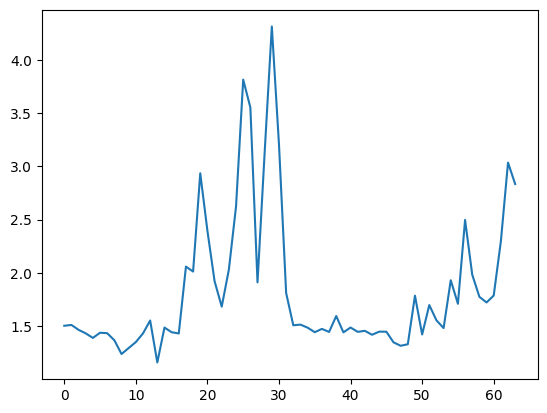

In [88]:
print(np.std(stability))
plt.plot(stability)
plt.show()

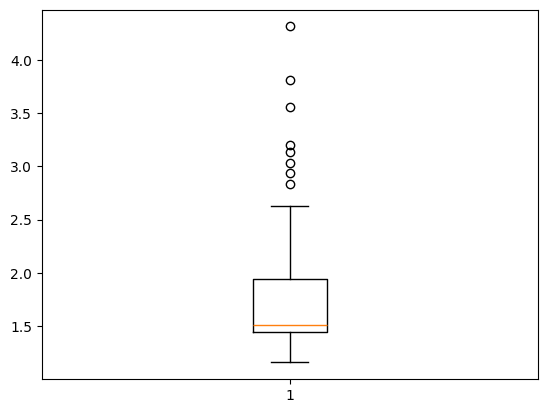

In [89]:
plt.boxplot(stability)
plt.show()